In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from keras.models import *
from keras.models import Sequential, Model  # Importar Model para modelos funcionales
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import numpy as np
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Input  # Importar Input para definir la entrada
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

In [64]:
#Carga de datos de los diferentes CSV´s
patient_data = pd.read_csv(r'C:\Users\piran\Documents\BOOTCAMP\FIN BOOTCAMP\PROYECTO FINAL\DATA 100\PatientCorePopulatedTable.txt', sep='\t') 
labs_data = pd.read_csv(r'C:\Users\piran\Documents\BOOTCAMP\FIN BOOTCAMP\PROYECTO FINAL\DATA 100\LabsCorePopulatedTable.txt', sep='\t')
diagnosis_data = pd.read_csv(r'C:\Users\piran\Documents\BOOTCAMP\FIN BOOTCAMP\PROYECTO FINAL\DATA 100\AdmissionsDiagnosesCorePopulatedTable.txt', sep='\t')
admisions_data = pd.read_csv(r"C:\Users\piran\Documents\BOOTCAMP\FIN BOOTCAMP\PROYECTO FINAL\DATA 100\AdmissionsCorePopulatedTable.txt", sep='\t')

In [66]:
#Para poder unir las tablas, necesitamos concatenar PatientID con su correpondiente AdmissionId para tener una clave única que relacione las tablas
labs_data["P+A"] = labs_data["PatientID"] + labs_data["AdmissionID"].map(str)
diagnosis_data["P+A"] = diagnosis_data["PatientID"] + diagnosis_data["AdmissionID"].map(str)
admisions_data["P+A"] = admisions_data["PatientID"] + admisions_data["AdmissionID"].map(str)

In [68]:
#Pivotamos la tabla de datos de laboratorio para que cada prueba sea una columna en lugar de una fila
labs_data_pivote = labs_data.pivot_table(index='P+A', columns=['LabName','LabUnits'], values='LabValue', fill_value=-100)

In [70]:
labs_data_pivote.isin([-100]).any().any()

True

In [72]:
#Para no tener dos niveles, concatenamos LabName y LabUnits
labs_data_pivote.columns = pd.MultiIndex.from_tuples(labs_data_pivote.columns, names=['LabName', 'LabUnits'])

# Concatenar los nombres de los niveles y establecer como índice único
labs_data_pivote.columns = labs_data_pivote.columns.get_level_values('LabName') + ' (' + labs_data_pivote.columns.get_level_values('LabUnits') + ')'

In [74]:
#Mergeamos labs_data_pivote y diagnosis_data
merged_df = pd.merge(labs_data_pivote, diagnosis_data, on='P+A')

#Mergeamos el anterior df con admisions_data
merged_df = pd.merge(merged_df, admisions_data, on='P+A', how='outer')

In [76]:
selected_columns = merged_df[['PatientID_x', 'PatientID_y']]

In [78]:
merged_df.columns

Index(['P+A', 'CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L

In [80]:
merged_df['PatientID'] = merged_df['PatientID_x']

In [82]:
# Luego, fusionamos el resultado con el tercer DataFrame
merged_df = pd.merge(merged_df, patient_data, on='PatientID', how='outer')

In [84]:
#Calculamos la edad de cada paciente en el momento de la admisión
merged_df['Edad'] = 2024 - pd.to_datetime(merged_df['PatientDateOfBirth']).dt.year

In [86]:
# Eliminar Columnas No Necesarias
merged_df.drop(['P+A', 'PatientDateOfBirth', 'PatientID_x', 'PatientID_y',
                'PrimaryDiagnosisDescription', 'PatientPopulationPercentageBelowPoverty',
                'AdmissionID_x', 'AdmissionID_y'
              ], axis=1, inplace=True)

In [88]:
# Función para determinar el capítulo basado en el diagnóstico
def obtener_capitulo(diagnostico):
    # Extraemos los primeros tres caracteres del diagnóstico
    codigo = diagnostico[:3]
    # Convertimos el código a un número
    codigo_num = ord(codigo[0]) * 100 + int(codigo[1:2])

    # Definimos los rangos y capítulos usando los valores ordinales
    capitulos = [
        (ord('A') * 100, ord('B') * 100 + 99, '1'),
        (ord('C') * 100, ord('D') * 100 + 48, '2'),
        (ord('D') * 100 + 50, ord('D') * 100 + 89, '3'),
        (ord('E') * 100, ord('E') * 100 + 90, '4'),
        (ord('F') * 100, ord('F') * 100 + 99, '5'),
        (ord('G') * 100, ord('G') * 100 + 99, '6'),
        (ord('H') * 100, ord('H') * 100 + 59, '7'),
        (ord('H') * 100 + 60, ord('H') * 100 + 95, '8'),
        (ord('I') * 100, ord('I') * 100 + 99, '9'),
        (ord('J') * 100, ord('J') * 100 + 99, '10'),
        (ord('K') * 100, ord('K') * 100 + 93, '11'),
        (ord('L') * 100, ord('L') * 100 + 99, '12'),
        (ord('M') * 100, ord('M') * 100 + 99, '13'),
        (ord('N') * 100, ord('N') * 100 + 99, '14'),
        (ord('O') * 100, ord('O') * 100 + 99, '15'),
        (ord('P') * 100, ord('P') * 100 + 96, '16'),
        (ord('Q') * 100, ord('Q') * 100 + 99, '17'),
        (ord('R') * 100, ord('R') * 100 + 99, '18'),
        (ord('S') * 100, ord('T') * 100 + 98, '19'),
        (ord('V') * 100, ord('Y') * 100 + 98, '20'),
        (ord('Z') * 100, ord('Z') * 100 + 99, '21'),
        (ord('U') * 100, ord('U') * 100 + 99, '22')
    ]

    # Comparamos el código numérico con los rangos definidos
    for inicio, fin, capitulo in capitulos:
        if inicio <= codigo_num <= fin:
            return capitulo
    return 'Capítulo no encontrado'

# Aplicamos la función a la columna de diagnósticos
merged_df['PrimaryDiagnosisChapter'] = merged_df['PrimaryDiagnosisCode'].apply(obtener_capitulo)

In [90]:
#Aplicamos OneHot encoder a las variables que no tienen demasiados datos distintos
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder()

# Ajustar y transformar las columnas 'PatientGender' y 'PatientMaritalStatus' con el encoder
encoded_columns = encoder.fit_transform(merged_df[['PatientGender', 'PatientMaritalStatus']])

# Convertir el resultado en una matriz densa
encoded_columns_dense = encoded_columns.toarray()

# Obtener los nombres de las nuevas columnas
column_names = encoder.get_feature_names_out(['PatientGender', 'PatientMaritalStatus'])

# Crear el DataFrame con los datos codificados y los nombres de columnas correctos
encoded_df = pd.DataFrame(encoded_columns_dense, columns=column_names)

# Concatenar el DataFrame codificado con el original, excluyendo las columnas originales
merged_df = pd.concat([merged_df.drop(['PatientGender', 'PatientMaritalStatus'], axis=1), encoded_df], axis=1)
df = merged_df
df

,CBC: ABSOLUTE LYMPHOCYTES (%),CBC: ABSOLUTE NEUTROPHILS (%),CBC: BASOPHILS (k/cumm),CBC: EOSINOPHILS (k/cumm),CBC: HEMATOCRIT (%),CBC: HEMOGLOBIN (gm/dl),CBC: LYMPHOCYTES (k/cumm),CBC: MCH (pg),CBC: MCHC (g/dl),CBC: MEAN CORPUSCULAR VOLUME (fl),...,Edad,PrimaryDiagnosisChapter,PatientGender_Female,PatientGender_Male,PatientMaritalStatus_Divorced,PatientMaritalStatus_Married,PatientMaritalStatus_Separated,PatientMaritalStatus_Single,PatientMaritalStatus_Unknown,PatientMaritalStatus_Widowed
0,21.050000,69.300000,0.125000,0.275000,43.500000,13.060000,3.650000,29.283333,32.280000,83.000000,...,64,15,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.850000,72.360000,0.080000,0.400000,39.380000,14.875000,3.500000,34.533333,33.600000,85.475000,...,64,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,24.240000,67.566667,0.077778,0.322222,35.712500,14.350000,2.850000,29.228571,32.211111,85.460000,...,64,9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22.571429,70.925000,0.083333,0.233333,41.200000,15.087500,3.733333,32.255556,33.257143,84.820000,...,64,15,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,28.383333,66.588889,0.166667,0.357143,44.250000,13.155556,3.280000,30.528571,32.944444,80.066667,...,64,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,25.566667,67.816667,0.100000,0.400000,42.442857,13.280000,3.022222,29.150000,33.400000,80.840000,...,69,11,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
368,25.383333,69.800000,0.122222,0.300000,47.200000,14.800000,2.528571,27.511111,32.366667,84.875000,...,69,2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
369,25.886667,68.686667,0.109091,0.357143,42.676923,14.309091,2.587500,29.636364,33.557143,87.193333,...,83,5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
370,27.800000,68.660000,0.085714,0.414286,40.614286,13.877778,3.360000,31.811111,34.154545,83.833333,...,83,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [92]:
#Como no podemos utilizar el formato datetime, obtenemos dos nuevas columnas calculando AdmissionDuration y TimeSinceLastAdmision

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


# Convertir fechas a datetime 
df['AdmissionStartDate'] = pd.to_datetime(df['AdmissionStartDate'])
df['AdmissionEndDate'] = pd.to_datetime(df['AdmissionEndDate'])

# Calcular la duración de la admisión y el tiempo desde la última admisión
df['AdmissionDuration'] = (df['AdmissionEndDate'] - df['AdmissionStartDate']).dt.total_seconds() / 3600
df = df.sort_values(['PatientID', 'AdmissionStartDate'])
df['TimeSinceLastAdmission'] = df.groupby('PatientID')['AdmissionStartDate'].diff().dt.total_seconds() / 3600


#
# Definir columnas numéricas y categóricas
numeric_columns = ['CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
                   'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
                   'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
                   'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
                   'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
                   'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
                   'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
                   'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
                   'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
                   'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
                   'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
                   'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
                   'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
                   'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
                   'METABOLIC: SODIUM (mmol/L)', 'METABOLIC: TOTAL PROTEIN (gm/dL)',
                   'URINALYSIS: PH (no unit)', 'URINALYSIS: RED BLOOD CELLS (rbc/hpf)',
                   'URINALYSIS: SPECIFIC GRAVITY (no unit)',
                   'URINALYSIS: WHITE BLOOD CELLS (wbc/hpf)', 'Edad',
                   'AdmissionDuration', 'TimeSinceLastAdmission']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#Aplicamos mapeo de frecuencia para no darle un peso quivocado a las variables
# Columnas para mapeo de frecuencia
frequency_map_columns = ['PatientLanguage', 'PrimaryDiagnosisCode', 'PatientRace']

# Aplicar mapeo de frecuencia
for col in frequency_map_columns:
    frequency_map = df[col].value_counts().to_dict()
    df[col] = df[col].map(frequency_map)

df = df.dropna(axis=0)
columns = [col for col in df.columns if col != 'PrimaryDiagnosisChapter'] + ['PrimaryDiagnosisChapter']
df = df[columns]

In [94]:
df.columns

Index(['CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L)', 'ME

In [96]:
#df.drop(columns=['AdmissionStartDate', 'AdmissionEndDate', 'PrimaryDiagnosisChapter_encoded', 'PatientID', 'PrimaryDiagnosisCode'], inplace=True)

In [98]:
from keras.preprocessing.sequence import pad_sequences

# Realiza el agrupamiento por 'PatientID' y ordena por 'AdmissionStartDate'
grouped = df.groupby('PatientID').apply(lambda x: x.sort_values('AdmissionStartDate')).reset_index(drop=True)
grouped.drop(['AdmissionStartDate', 'AdmissionEndDate'], axis=1, inplace=True)
# Encuentra la longitud máxima de secuencia
max_sequence_length = grouped.groupby('PatientID').size().max()
print(f'MAX_SEQUENCE =', max_sequence_length)
# Prepara tus datos para el relleno


#Suponiendo que 'sequences' es una lista de DataFrames y que 'label_column' es el nombre de tu columna de etiquetas
sequences = [group for _, group in grouped.groupby('PatientID')]
labels = [seq['PrimaryDiagnosisChapter'].iloc[-1] for seq in sequences]  # Extraer las etiquetas
sequences = [seq.drop(columns=['PrimaryDiagnosisChapter']) for seq in sequences]  # Eliminar la columna de etiquetas

# Aplicar relleno

sequences = [df.drop(columns=['PrimaryDiagnosisCode','PatientID']) for df in sequences]
# Rellena las secuencias
padded_sequences = pad_sequences([seq.values for seq in sequences], maxlen=max_sequence_length, padding='post', dtype='float32')
#padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')
sequences = padded_sequences

MAX_SEQUENCE = 6


In [100]:
padded_sequences[0][5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [102]:
df

,CBC: ABSOLUTE LYMPHOCYTES (%),CBC: ABSOLUTE NEUTROPHILS (%),CBC: BASOPHILS (k/cumm),CBC: EOSINOPHILS (k/cumm),CBC: HEMATOCRIT (%),CBC: HEMOGLOBIN (gm/dl),CBC: LYMPHOCYTES (k/cumm),CBC: MCH (pg),CBC: MCHC (g/dl),CBC: MEAN CORPUSCULAR VOLUME (fl),...,PatientGender_Male,PatientMaritalStatus_Divorced,PatientMaritalStatus_Married,PatientMaritalStatus_Separated,PatientMaritalStatus_Single,PatientMaritalStatus_Unknown,PatientMaritalStatus_Widowed,AdmissionDuration,TimeSinceLastAdmission,PrimaryDiagnosisChapter
1,29.850000,72.360000,0.080000,0.400000,39.380000,14.875000,3.500000,34.533333,33.600000,85.475000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,167.631404,100899.399949,4
2,24.240000,67.566667,0.077778,0.322222,35.712500,14.350000,2.850000,29.228571,32.211111,85.460000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,271.985275,12258.349332,9
3,22.571429,70.925000,0.083333,0.233333,41.200000,15.087500,3.733333,32.255556,33.257143,84.820000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,215.713584,12169.230583,15
4,28.383333,66.588889,0.166667,0.357143,44.250000,13.155556,3.280000,30.528571,32.944444,80.066667,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,252.464069,60756.211734,5
6,27.045455,70.425000,0.125000,0.391667,43.053846,14.918182,3.141667,29.644444,33.742857,87.611111,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,350.446748,168607.368660,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,21.700000,67.600000,0.100000,0.400000,37.587500,13.816667,3.383333,35.771429,35.600000,86.744444,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,223.532839,23496.404714,2
367,25.566667,67.816667,0.100000,0.400000,42.442857,13.280000,3.022222,29.150000,33.400000,80.840000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,251.901085,156308.911006,11
368,25.383333,69.800000,0.122222,0.300000,47.200000,14.800000,2.528571,27.511111,32.366667,84.875000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,195.687260,121890.763498,2
370,27.800000,68.660000,0.085714,0.414286,40.614286,13.877778,3.360000,31.811111,34.154545,83.833333,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,268.252095,275723.108959,2


In [104]:

dimensiones = padded_sequences.shape
print("Las dimensiones de 'padded_sequences' son:", dimensiones)

Las dimensiones de 'padded_sequences' son: (96, 6, 48)


In [106]:
X = padded_sequences[:, :, :-1]

In [108]:
X[0][0]

array([2.9850000e+01, 7.2360001e+01, 7.9999998e-02, 4.0000001e-01,
       3.9380001e+01, 1.4875000e+01, 3.5000000e+00, 3.4533333e+01,
       3.3599998e+01, 8.5474998e+01, 4.4285715e-01, 6.1500001e+00,
       2.7032001e+02, 1.3200000e+01, 4.8800001e+00, 7.7166667e+00,
       5.1599998e+00, 9.8260002e+01, 3.3625000e+01, 9.1333332e+00,
       2.4174999e+01, 4.4000000e-01, 1.4414286e+01, 1.0700000e+01,
       2.6716667e+01, 1.0372000e+02, 8.1428570e-01, 1.0258000e+02,
       4.9200001e+00, 1.3738000e+02, 6.7500000e+00, 6.1428571e+00,
       2.0999999e+00, 1.0000000e+00, 2.4000001e+00, 1.8900000e+02,
       2.4200000e+02, 6.4000000e+01, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 1.6763141e+02], dtype=float32)

In [110]:
y = np.array(labels)

In [114]:
import numpy as np
from keras.utils import to_categorical

# Convertir las etiquetas de string a enteros
y_integers = np.array(y, dtype=int)  # Usar 'int' en lugar de 'np.int'

# Calcular el número de clases únicas
num_classes = np.max(y_integers) + 1

# Convertir las etiquetas a formato one-hot
y_one_hot = to_categorical(y_integers, num_classes=num_classes)


In [116]:
y = y_one_hot

In [118]:
#X = padded_sequences[:, :, :-1]
#y = padded_sequences[:, -1, -1]
#y = np.array(labels)
#y = to_categorical(y, num_classes=num_classes)
#y = to_categorical(y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Normalizar los datos numéricos
scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_train = X_train_normalized.reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_normalized = scaler.transform(X_test_reshaped)
X_test = X_test_normalized.reshape(X_test.shape)

In [120]:
print(f"la dimension de y es",y.shape)

la dimension de y es (96, 22)


In [122]:
print(f"la dimension de X es",X.shape)

la dimension de X es (96, 6, 47)


In [127]:
X_train.shape

(76, 6, 47)

In [129]:
y_test.shape

(20, 22)

In [131]:
y_train.shape

(76, 22)

In [133]:
X_test.shape

(20, 6, 47)

In [135]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Modelo
model = Sequential([
    # La capa Input no es necesaria aquí, ya que LSTM espera una entrada tridimensional
    LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    LSTM(128, kernel_regularizer=l2(0.001)),  # return_sequences=False por defecto
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Asegúrate de que esta capa coincida con el número de clases
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_100k.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=300, batch_size=4096, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint, lr_scheduler])

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Resumen del modelo
model.summary()


Epoch 1/300


C:\Users\piran\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0921 - loss: 4.3344 - val_accuracy: 0.0500 - val_loss: 4.3318 - learning_rate: 1.0000e-05
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.0789 - loss: 4.3328 - val_accuracy: 0.1000 - val_loss: 4.3311 - learning_rate: 1.0000e-05
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.0395 - loss: 4.3334 - val_accuracy: 0.1000 - val_loss: 4.3304 - learning_rate: 1.0000e-05
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0395 - loss: 4.3325 - val_accuracy: 0.1000 - val_loss: 4.3296 - learning_rate: 1.0000e-05
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0921 - loss: 4.3299 - val_accuracy: 0.1000 - val_loss: 4.3288 - learning_rate: 1.0000e-05
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0263 - loss: 4.3311 - val_accuracy: 0.1000 - val_loss: 4.3280 - learning_rate: 1.0000e-05
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.0395 - loss: 4.3312 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 6, 512)         │     1,146,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 6, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 22)             │           726 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,427,556 (24.52 MB)

 Trainable params: 2,142,518 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,285,038 (16.35 MB)

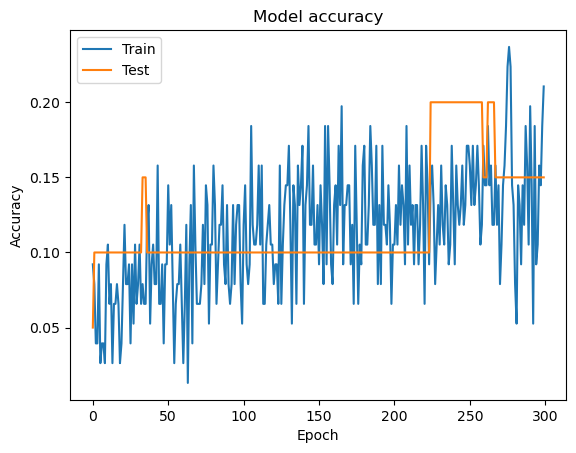

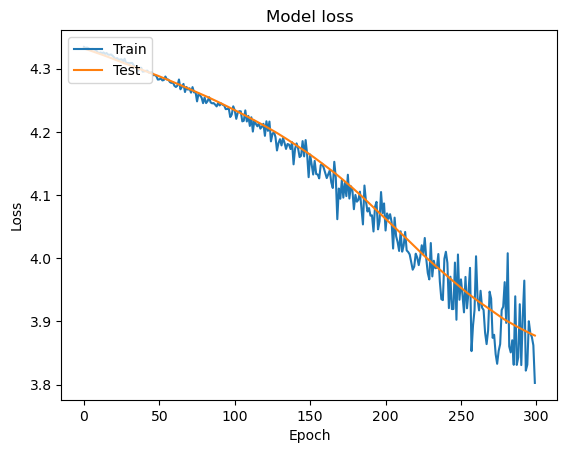

In [136]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Accuracy: 0.2
F1 Score: 0.06666666666666667
Confusion Matrix:
[[0 1 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]]


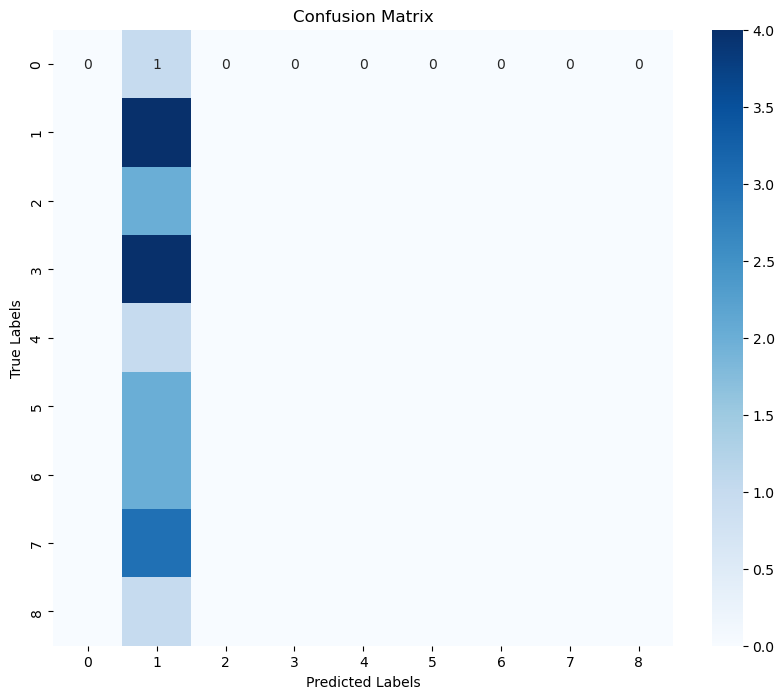

In [40]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.utils import to_categorical

# Suponiendo que 'y_test' y las predicciones del modelo están en formato de etiquetas enteras
# Si 'y_test' está en formato one-hot, primero conviértelo a etiquetas enteras
y_test_labels = np.argmax(y_test, axis=1)

# Realizar predicciones con el modelo
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular la precisión
accuracy = accuracy_score(y_test_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Calcular el puntaje F1
f1 = f1_score(y_test_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1}')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Visualizar la matriz de confusión
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
yhat = model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [42]:
yhat_metrica = [np.argmax(x) for x in yhat]
y_test_metrica = [np.argmax(x) for x in y_test]

In [43]:
from sklearn.metrics import confusion_matrix

for x in confusion_matrix(y_test_metrica, yhat_metrica):
    print(list(x))

[0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 4, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 4, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0]


In [44]:
from sklearn.metrics import f1_score, classification_report

# Suponiendo que 'y_pred' son las predicciones de tu modelo y 'y_true' son las etiquetas verdaderas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular el F1-score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'F1-score: {f1}')

# Para obtener un reporte completo con precision, recall y F1-score por clase
print(classification_report(y_true_classes, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
F1-score: 0.06666666666666667
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.20      1.00      0.33         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1

    accuracy                           0.20        20
   macro avg       0.02      0.11      0.04        20
weighted avg       0.04      0.20      0.07        20



C:\Users\piran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\piran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\piran\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


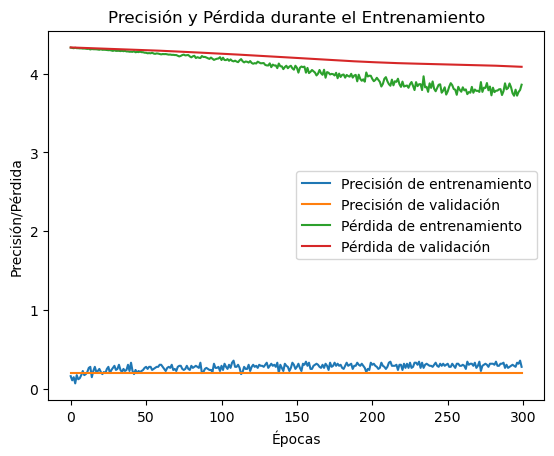

In [45]:
# Precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')

# Pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')

# Títulos y etiquetas
plt.title('Precisión y Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión/Pérdida')
plt.legend()

# Mostrar la gráfica
plt.show()


In [46]:
import numpy as np

# Asumimos que 'merge_merged_df' es tu DataFrame y 'X_train' es tu conjunto de entrenamiento

# Seleccionar la primera fila de 'merge_merged_df' para hacer la predicción
input_data = merged_df.iloc[0]
input_data = input_data.drop(['PrimaryDiagnosisChapter', 'PrimaryDiagnosisCode'])

# Asegurarte de que el formato de la fila sea compatible con el modelo
# Convertir la fila en un array de numpy y redimensionar para que tenga la forma (1, num_features)
input_data = np.array(input_data).reshape(1, -1)

# Hacer la predicción
prediction = model.predict(input_data)

# Mostrar la predicción
clase_predicha = np.argmax(prediction, axis=1)
print(f'Predicción: {prediction}')
print("La clase predicha es:", clase_predicha)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Definir las características estáticas y dinámicas fuera de la función
static_features = ['PatientID', 'PatientRace', 'PatientLanguage', 'Edad', 'PatientGender_Female', 'PatientGender_Male',
                   'PatientMaritalStatus_Divorced', 'PatientMaritalStatus_Married', 'PatientMaritalStatus_Separated',
                   'PatientMaritalStatus_Single', 'PatientMaritalStatus_Unknown', 'PatientMaritalStatus_Widowed']

# Asumiendo que df es tu DataFrame
all_features = df.columns.tolist()
dynamic_features = [col for col in all_features if col not in static_features + ['AdmissionStartDate', 'AdmissionEndDate', 'PrimaryDiagnosisCode', 'PrimaryDiagnosisChapter']]

def create_sequences(patient_data, seq_length, time_col='AdmissionStartDate', target_col='PrimaryDiagnosisCode'):
    patient_data = patient_data.sort_values(time_col)
    sequences = []
    labels = []
    
    for i in range(len(patient_data) - seq_length + 1):
        seq = patient_data[dynamic_features].iloc[i:i+seq_length].values
        static = patient_data[static_features].iloc[i].values
        label = patient_data[target_col].iloc[i+seq_length-1]
        
        # Añadir características derivadas del tiempo
        time_features = [
            (patient_data[time_col].iloc[i+seq_length-1] - patient_data[time_col].iloc[i]).days,  # Duración de la secuencia
            patient_data['AdmissionDuration'].iloc[i+seq_length-1],
            patient_data['TimeSinceLastAdmission'].iloc[i+seq_length-1]
        ]
        
        sequences.append(np.concatenate([seq.flatten(), static, time_features]))
        labels.append(label)
    
    return sequences, labels

# Preparación de los datos
df['AdmissionStartDate'] = pd.to_datetime(df['AdmissionStartDate'])
df['AdmissionEndDate'] = pd.to_datetime(df['AdmissionEndDate'])

grouped = df.groupby('PatientID')
all_sequences = []
all_labels = []
seq_length = 5  # Definimos seq_length aquí

for _, group in grouped:
    if len(group) >= seq_length:
        seqs, labs = create_sequences(group, seq_length=seq_length)
        all_sequences.extend(seqs)
        all_labels.extend(labs)

X = np.array(all_sequences)
y = np.array(all_labels)

# Normalización de las características dinámicas
dynamic_features_count = len(dynamic_features) * seq_length
scaler = StandardScaler()
X[:, :dynamic_features_count] = scaler.fit_transform(X[:, :dynamic_features_count])

# Ahora X e y están listos para ser utilizados en tu modelo
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (16, 200)
Forma de y: (16,)


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(seq_length, len(dynamic_features))),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='softmax')  # Asumiendo clasificación multiclase
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X para LSTM: (muestras, pasos de tiempo, características)
X_reshaped = X[:, :dynamic_features_count].reshape((-1, seq_length, len(dynamic_features)))

# Añadir características estáticas y temporales
X_static = X[:, dynamic_features_count:]

model.fit([X_reshaped, X_static], y, epochs=50, batch_size=32, validation_split=0.2)

C:\Users\piran\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [51]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate

# Asegúrate de que X e y sean del tipo correcto
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# Reshape X para LSTM: (muestras, pasos de tiempo, características)
dynamic_features_count = len(dynamic_features) * seq_length
X_reshaped = X[:, :dynamic_features_count].reshape((-1, seq_length, len(dynamic_features)))

# Añadir características estáticas y temporales
X_static = X[:, dynamic_features_count:]

# Definir el modelo usando la API funcional
input_lstm = Input(shape=(seq_length, len(dynamic_features)))
input_static = Input(shape=(X_static.shape[1],))

lstm_out = LSTM(64)(input_lstm)
lstm_out = Dropout(0.2)(lstm_out)

combined = Concatenate()([lstm_out, input_static])
dense1 = Dense(32, activation='relu')(combined)
dense1 = Dropout(0.2)(dense1)
output = Dense(len(np.unique(y)), activation='softmax')(dense1)

model = Model(inputs=[input_lstm, input_static], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Imprimir un resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit([X_reshaped, X_static], y, epochs=50, batch_size=32, validation_split=0.2)

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate([X_reshaped, X_static], y)
print(f"Test accuracy: {test_accuracy}")

ValueError: could not convert string to float: '21792512-2D40-4326-BEA2-A40127EB24FF'